In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
matplotlib.style.use("ggplot")

In [3]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plotly.io.renderers.default = "notebook_connected" # to get plots offline

# Read csv data

In [4]:
data_folder = "/kaggle/input/hotel-id-2021-fgvc8/"

In [5]:
train_df = pd.read_csv(data_folder + "train.csv", parse_dates=["timestamp"])
submission_df = pd.read_csv(data_folder + "sample_submission.csv")

# Look at csv data

## Train data

In [6]:
train_df.head()

image  chain  hotel_id           timestamp
0  8000d59f6a3d765f.jpg     85     24607 2018-11-28 05:42:31
1  8000febe81817f7f.jpg      6     25389 2017-01-01 07:01:46
2  80053befc2d42fba.jpg      3       672 2018-01-26 13:22:07
3  8007fa0a8fe89f9d.jpg      5     63866 2020-07-03 02:31:31
4  800a4a6b6f6d2df6.jpg      0     12036 2017-09-22 17:59:22

In [7]:
print("Number of records: {}".format(len(train_df)))
print("Number of images: {}".format(train_df["image"].unique().size))
print("Number of chains: {}".format(train_df["chain"].unique().size))
print("Number of hotels: {}".format(train_df["hotel_id"].unique().size))
print("Newest image: {}".format(train_df["timestamp"].max()))
print("Oldest image: {}".format(train_df["timestamp"].min()))

Number of records: 97556
Number of images: 97554
Number of chains: 88
Number of hotels: 7770
Newest image: 2020-10-16 04:22:30
Oldest image: 2015-07-06 14:57:38


There seems to be some duplicated images so let's look at them

In [8]:
train_df[train_df["image"].duplicated(keep=False)]

image  chain  hotel_id           timestamp
56845  c7c7383898d76598.jpg      6     60918 2020-07-18 00:03:38
56846  c7c7383898d76598.jpg      6     60918 2020-08-29 04:35:13
62238  ce27d36c9147cc19.jpg      6     60918 2020-07-18 00:03:38
62239  ce27d36c9147cc19.jpg      6     60918 2020-08-29 04:35:13

Doesn't look that bad, just 2 duplicates but they belong to same hotel so we can simple drop them

In [9]:
train_df = train_df.drop_duplicates(subset=["image"], keep="first")

Look at the chain values per hotel, a hotel should belong to one chain

In [10]:
group_df = train_df.groupby("hotel_id").agg({"chain": [pd.Series.nunique, pd.Series.unique, "max"]})
group_df.columns = ["_".join(x) for x in group_df.columns.ravel()]
group_df.sort_values("chain_nunique")[::-1].head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



chain_nunique chain_unique  chain_max
hotel_id                                       
9760                  2       [0, 3]          3
28721                 2       [3, 0]          3
62488                 2       [0, 7]          7
20229                 2       [0, 3]          3
21382                 1            5          5

There are some hotels that belong to multiple chains though


In [11]:
hotels_df = train_df[train_df["hotel_id"].isin(group_df[group_df["chain_nunique"] > 1].index)]
hotels_group_df = hotels_df.groupby(["hotel_id", "chain"]).size().to_frame("image_count").reset_index()

fig = px.bar(hotels_group_df, x="hotel_id", y="image_count", color=hotels_group_df["chain"].astype(str))
fig.update_xaxes(title_text="Hotel ID", type="category")
fig.update_yaxes(title_text="Image count")
fig.update_layout(title="Image count per hotel and chain", legend=dict(title="Chain"))
fig.show()

which is explained [here](https://www.kaggle.com/c/hotel-id-2021-fgvc8/discussion/230768#1264813) by the host:
> During the process of prepping the dataset, we discovered a few hotels that needed to be merged -- that is, there were two different IDs that referred to the same hotel. It would seem that when we did this merging, the chain ended up getting both the "unknown" label (0) and the correct label (whatever the non-zero chain number is). So you can use the non-zero label!

So we can fix the data accordingly by taking the non zero chain

In [12]:
train_df = pd.read_csv(data_folder + "train.csv", parse_dates=["timestamp"])
group_df = train_df.groupby("hotel_id").agg({"chain": "max"}).reset_index()
train_df = train_df.merge(group_df[["hotel_id", "chain"]], on="hotel_id", suffixes=("", "_new"))

And check that the data is fixed

In [13]:
group_df = train_df.groupby("hotel_id").agg({"chain": [pd.Series.nunique, pd.Series.unique], "chain_new": [pd.Series.nunique, pd.Series.unique]})
group_df.sort_values(("chain", "nunique"))[::-1].head()

chain         chain_new       
         nunique  unique   nunique unique
hotel_id                                 
9760           2  [0, 3]         1      3
28721          2  [3, 0]         1      3
62488          2  [0, 7]         1      7
20229          2  [0, 3]         1      3
21382          1       5         1      5

Looks good so we can replace the old chain column with the new chain

In [14]:
train_df["chain"] = train_df["chain_new"]
train_df.drop(columns=["chain_new"], inplace=True)

## Submission

In [15]:
submission_df.head()

image                       hotel_id
0  99e91ad5f2870678.jpg  36363 53586 18807 64314 60181
1  b5cc62ab665591a9.jpg  36363 53586 18807 64314 60181
2  d5664a972d5a644b.jpg  36363 53586 18807 64314 60181

## Chains

In [16]:
chain_group_df = train_df.groupby(["chain"]).agg({"hotel_id": [pd.Series.nunique], "image" : [pd.Series.nunique]})
chain_group_df.columns = ["_".join(x) for x in chain_group_df.columns.ravel()]
chain_group_df = chain_group_df.reset_index().sort_values("hotel_id_nunique")[::-1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



In [17]:
# fig = make_subplots(rows=2, cols=1, vertical_spacing=0.02, shared_xaxes=True,)

# fig.add_trace(go.Bar(x=group_df["chain"].astype(str), y=group_df["hotel_id_nunique"], showlegend = False, name="Hotel count"), 1, 1)
# fig.add_trace(go.Bar(x=group_df["chain"].astype(str), y=group_df["image_nunique"], showlegend = False, name="Image count"), 2, 1)

# fig.update_yaxes(title_text="Hotel count", row=1, col=1)
# fig.update_yaxes(title_text="Image count", row=2, col=1)
# fig.update_xaxes(title_text="Hotel ID", row=2, col=1)
# fig.show()

In [18]:
fig = px.scatter(chain_group_df, x="chain", y="hotel_id_nunique",
                 size="image_nunique", color = "image_nunique",
                 hover_name = None,
                 log_y=True, size_max=75)

fig.update_yaxes(title_text="Hotel count")
fig.update_xaxes(title_text="Chain ID")
fig.update_layout(title="Hotel and image count per chain", coloraxis=dict(colorbar=dict(title="Image count")))
fig.update_traces(hovertemplate="Chain: %{x} <br>Hotel count: %{y}<br>Image count: %{marker.size}")
fig.show()

In [19]:
group_df = train_df.groupby(["chain", "hotel_id"]).size().to_frame("image_count").reset_index()

In [20]:
big_chains = chain_group_df[chain_group_df["hotel_id_nunique"] >= 75]["chain"].values
mid_chains = chain_group_df[(chain_group_df["hotel_id_nunique"] < 75) & (chain_group_df["hotel_id_nunique"] >= 10)]["chain"].values
small_chains = chain_group_df[chain_group_df["hotel_id_nunique"] < 10]["chain"].values

In [21]:
fig = px.box(group_df[group_df["chain"].isin(big_chains)], x="chain", y="image_count", height=350)
fig.update_xaxes(title_text="Chain ID", type="category")
fig.update_layout(title="Image count per hotel: Big chains (75 hotels and more)")
fig.show()

fig = px.box(group_df[group_df["chain"].isin(mid_chains)], x="chain", y="image_count", height=350)
fig.update_xaxes(title_text="Chain ID", type="category")
fig.update_layout(title="Image count per hotel: Mid chains (10-75 hotels)")
fig.show()

fig = px.box(group_df[group_df["chain"].isin(small_chains)], x="chain", y="image_count", height=350)
fig.update_xaxes(title_text="Chain ID", type="category")
fig.update_layout(title="Image count per hotel: Small chains (less than 10 hotels)")
fig.show()

## Hotels

In [22]:
group_df = train_df.groupby(["hotel_id"]).size().to_frame("image_count").sort_values("image_count")[::-1].reset_index()

# top and low
low_df = group_df.iloc[-50:]
top_df = group_df.iloc[:50]

fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"colspan": 2}, None], [{}, {}]],
                    horizontal_spacing=0.02, vertical_spacing=0.2, 
                    shared_yaxes=True,
                    subplot_titles=("", "Top 50", "Bottom 50"))


fig.add_trace(go.Scatter(x=group_df["hotel_id"], y=group_df["image_count"], showlegend = False), 1, 1)
fig.add_trace(go.Bar(x=top_df["hotel_id"], y=top_df["image_count"], showlegend = False), 2, 1)
fig.add_trace(go.Bar(x=low_df["hotel_id"], y=low_df["image_count"], showlegend = False), 2, 2)

fig.update_yaxes(title_text="Image count", row=1, col=1)
fig.update_yaxes(title_text="Image count", row=2, col=1)
fig.update_xaxes(type="category", visible=False, row=1, col=1)
fig.update_xaxes(title_text="Hotel ID", type="category", row=2, col=1)
fig.update_xaxes(title_text="Hotel ID", type="category", row=2, col=2)

fig.update_layout(title="Image count per hotel", height=550)
fig.show()

In [23]:
fig = px.histogram(group_df, x="image_count", nbins=25, marginal="box", height=500)
fig.update_layout(title="Distribution of image count per hotel")
fig.update_traces(hovertemplate="Image count: %{x} <br>Hotel count: %{y}")
fig.show()

## Timestamps

In [24]:
group_df = train_df.groupby([train_df["timestamp"].dt.to_period("M")])["image"].count().reset_index()

fig = px.bar(group_df, x=group_df["timestamp"].astype(str), y="image")
fig.update_yaxes(title_text="Image count")
fig.update_xaxes(title_text="Time", type="category")
fig.update_layout(title="Image count by months", height=350)
fig.show()

In [25]:
hotel_df = train_df[train_df["hotel_id"] == 53586]
group_df = hotel_df.groupby([hotel_df["timestamp"].dt.to_period("M")])["image"].count().reset_index()

fig = px.bar(group_df, x=group_df["timestamp"].astype(str), y="image")
fig.update_yaxes(title_text="Image count")
fig.update_xaxes(title_text="Time", type="category")
fig.update_layout(title="Image count by months for hotel 53586", height=350)
fig.show()

In [26]:
group_df = train_df.groupby([train_df["timestamp"].dt.to_period("M"), "chain"])["image"].count().reset_index()

fig = px.scatter(group_df, x=group_df["timestamp"].astype(str), y="chain",
                 size="image", color = "image",
                 hover_name = None,
                 size_max=25)

fig.update_yaxes(title_text="Chain", type="category")
fig.update_xaxes(title_text="Time")
fig.update_layout(title="Image count by months for chains", coloraxis=dict(colorbar=dict(title="Image count")))
fig.update_traces(hovertemplate="Time: %{x} <br>Chain: %{y}<br>Image count: %{marker.size}")
fig.show()

In [27]:
chain_df = train_df[train_df["chain"] == 6]
group_df = chain_df.groupby([chain_df["timestamp"].dt.to_period("M"), "hotel_id"])["image"].count().reset_index()

fig = px.scatter(group_df, x=group_df["timestamp"].astype(str), y="hotel_id",
                 size="image", color = "image",
                 hover_name = None,
                 size_max=25)

fig.update_yaxes(title_text="Hotel", type="category")
fig.update_xaxes(title_text="Time")
fig.update_layout(title="Image count by months for hotels of chain 6", coloraxis=dict(colorbar=dict(title="Image count")))
fig.update_traces(hovertemplate="Time: %{x} <br>Hotel: %{y}<br>Image count: %{marker.size}")
fig.show()

# Look at images

In [28]:
from PIL import Image

In [29]:
def open_image(row_df):
    return Image.open(f"{data_folder}train_images/{row_df.chain.astype(int)}/{row_df.image}")


def select_data(data_df, chain_id, hotel_id, N):   
    if hotel_id is not None:
        sub_df = data_df[data_df["hotel_id"] == hotel_id]
    elif chain_id is not None:
        sub_df = data_df[data_df["chain"] == chain_id]
    else:
        sub_df = data_df
        
    if N is not None:
        sub_df = sub_df.sample(N)
    
    return sub_df


def show_images(data_df, nrows=None, ncols=None, fig_title=None):
    N = len(data_df)
    
    if nrows is None:
        nrows = 1
    if ncols is None:
        ncols = N
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(24,int(5*nrows)))
    if not isinstance(axs, np.ndarray):
        axs = np.array(axs)
        
    axs = axs.ravel()
    
    for i in range(0, N):
        row_df = data_df.iloc[i]
        image = open_image(row_df)
        axs[i].imshow(image)
        axs[i].set_title(f"{row_df.chain}:{row_df.hotel_id}:{row_df.image}\n" + 
                          f"Time: {row_df.timestamp}\n" + 
                          f"Size: {np.shape(image)}")
        axs[i].axis("off")
        
    if fig_title is not None:
        fig.suptitle(fig_title, fontsize=16)

### Random sample of 10 images

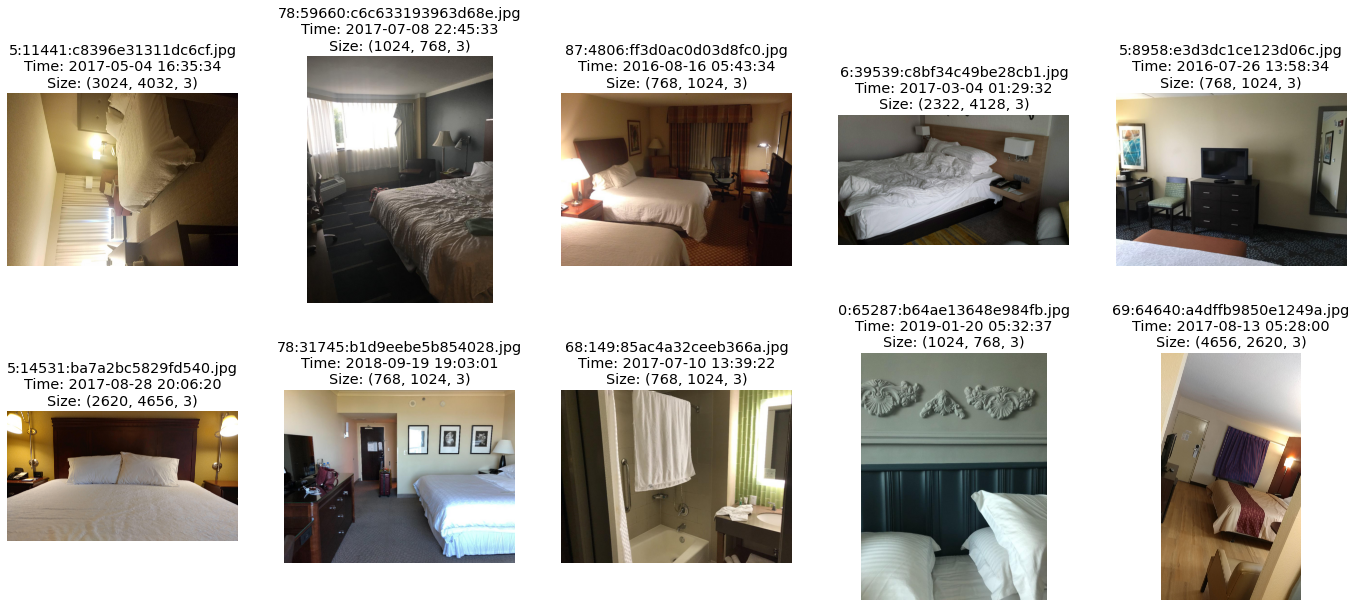

In [30]:
sample_df = select_data(train_df, None, None, 10)
show_images(sample_df, 2, 5)

### 5 sample images of hotel 48897

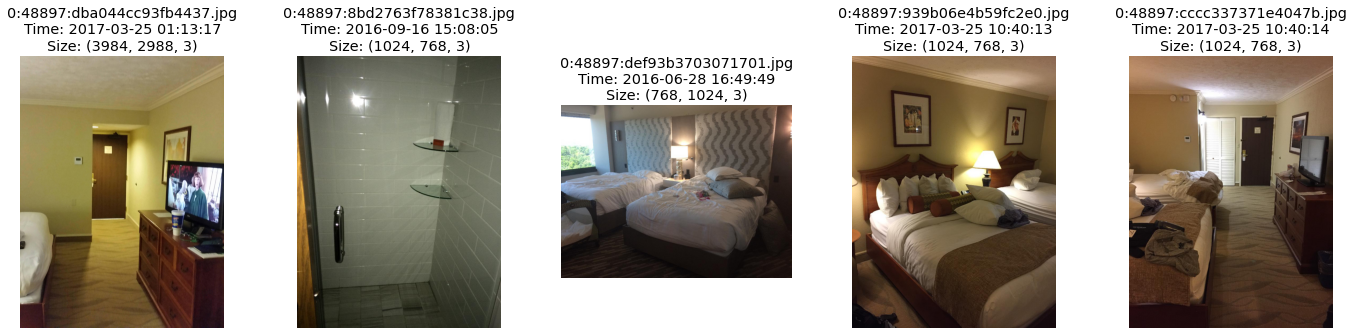

In [31]:
sample_df = select_data(train_df, None, 48897, 5)
show_images(sample_df)

## Check image sizes

In [32]:
N = 500

In [33]:
sample_df = select_data(train_df, None, None, N)
x_array = []
y_array = []
z_array = []

for i in range(0, N):
    I = open_image(sample_df.iloc[i])
    x, y, z = np.shape(I)
    x_array.append(x)
    y_array.append(y)
    z_array.append(z)

In [34]:
pd.DataFrame(data={"x": x_array, "y": y_array}).describe()

x            y
count   500.000000   500.000000
mean   1436.780000  1563.636000
std    1079.724298  1261.959416
min     576.000000   576.000000
25%     768.000000   768.000000
50%    1024.000000  1024.000000
75%    1024.000000  1024.000000
max    5344.000000  5344.000000

In [35]:
fig = go.Figure()
fig.add_trace(go.Box(x=z_array, name="Z", boxpoints="all"))
fig.add_trace(go.Box(x=y_array, name="Y", boxpoints="all"))
fig.add_trace(go.Box(x=x_array, name="X", boxpoints="all"))
fig.update_yaxes(title="Axis")
fig.update_xaxes(title="Pixels")
fig.update_layout(title=f"Box plots of image dimensions based on {N} samples")
fig.show()

In [36]:
dim_array = np.array(x_array) * y_array

fig = go.Figure()
fig.add_trace(go.Box(x=dim_array, name="X*Y", boxpoints="all"))
fig.update_xaxes(title="Pixels")
fig.update_layout(title=f"Box plots of image dimension based on {N} samples", height=250)
fig.show()

### Images with biggest dimensions

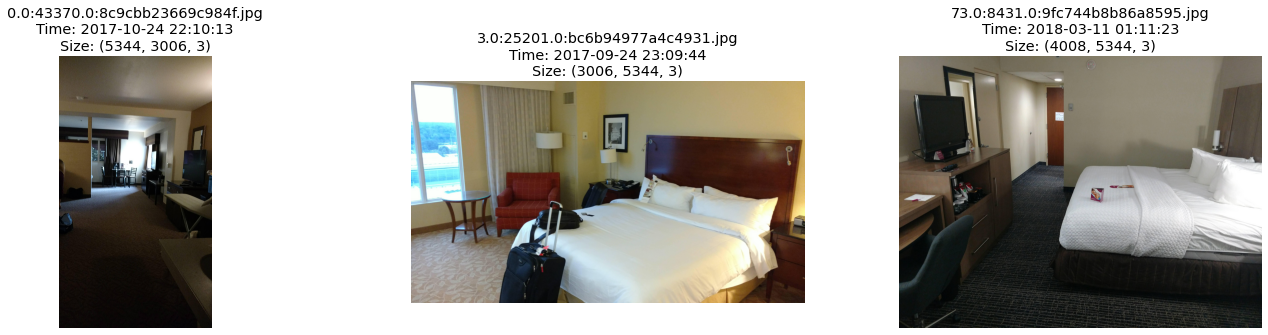

In [37]:
max_x = sample_df.iloc[np.argmax(x_array)]
max_y = sample_df.iloc[np.argmax(y_array)]
max_dim = sample_df.iloc[np.argmax(dim_array)]

df = pd.DataFrame()
df = df.append(max_x)
df = df.append(max_y)
df = df.append(max_dim)
show_images(df)

## Chains with low image or hotel count

### Chain 18 - 1 hotel with 8 images

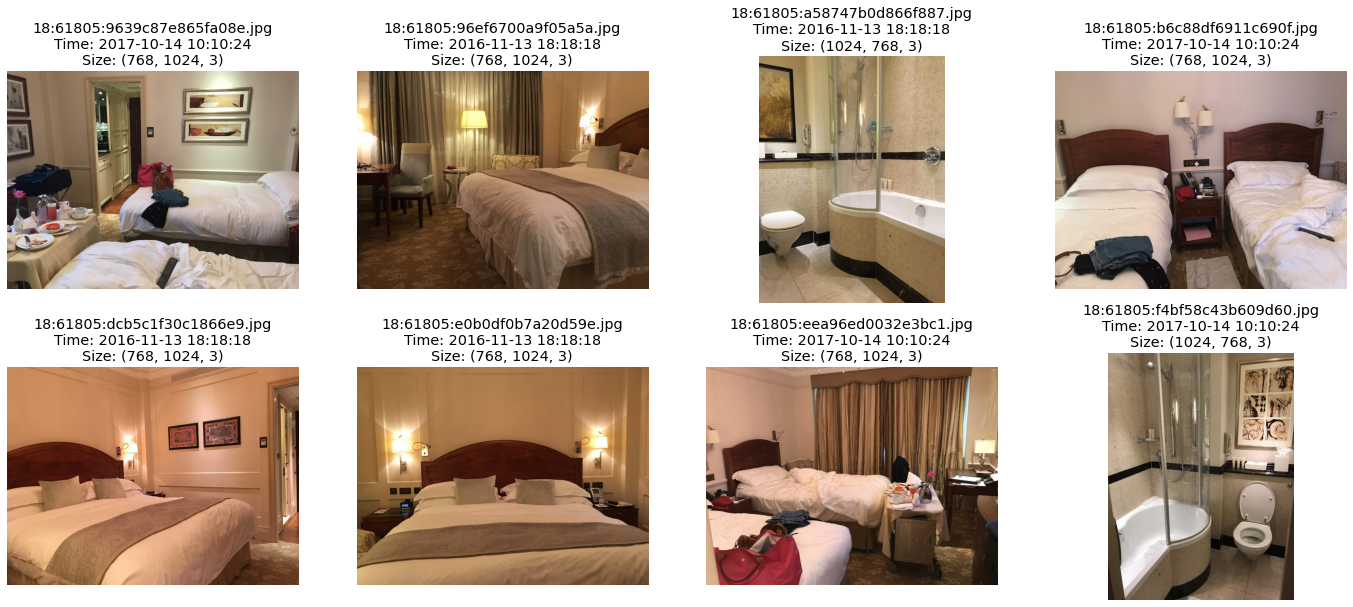

In [38]:
sample_df = select_data(train_df, 18, None, None)
show_images(sample_df, 2, 4)

### Chain 58 - 2 hotels with total 13 images

In [39]:
sample_df = select_data(train_df, 58, None, None)

#### Hotel 4300

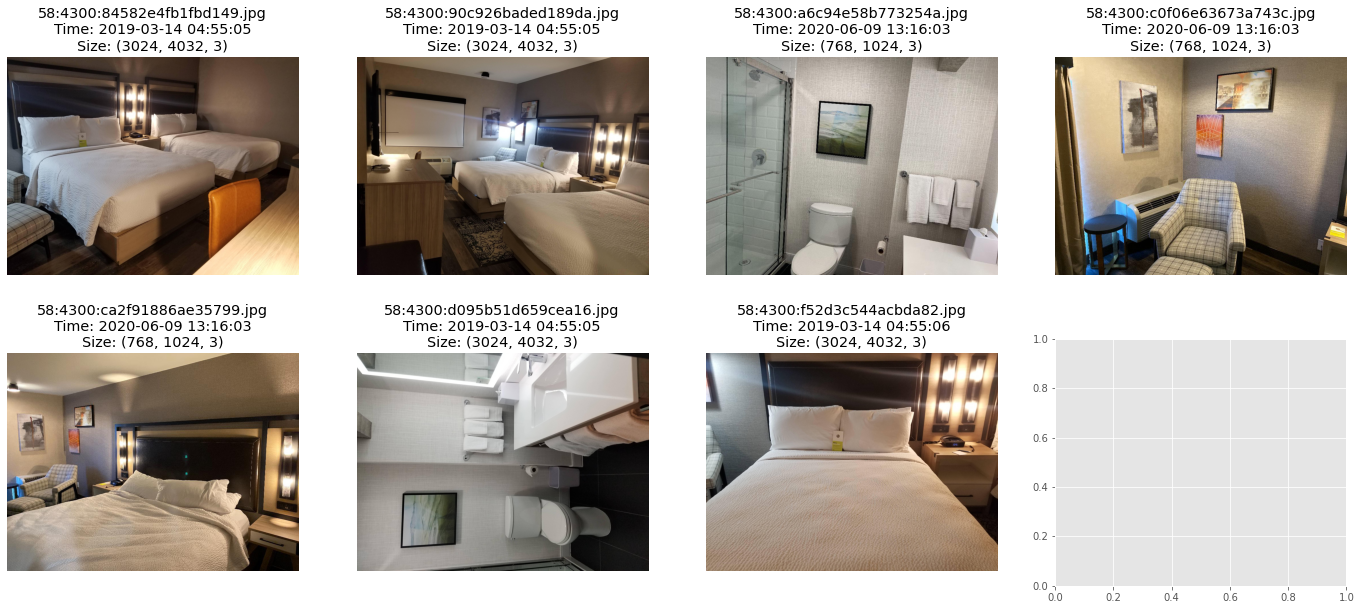

In [40]:
show_images(sample_df[sample_df["hotel_id"] == 4300], 2, 4)

#### Hotel 56113

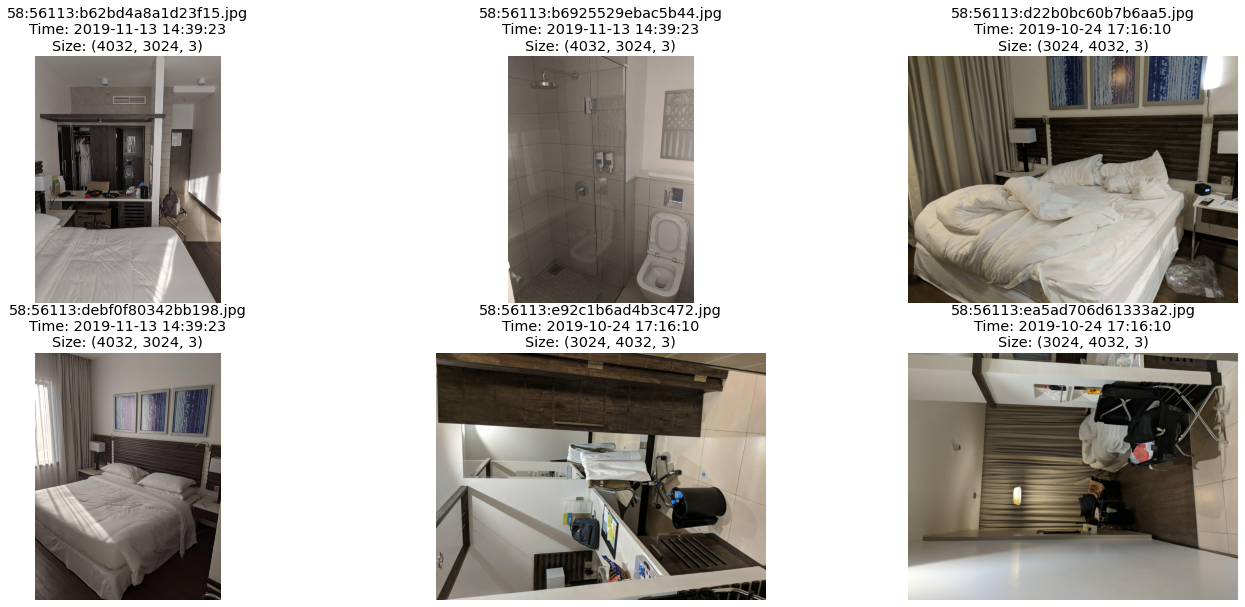

In [41]:
show_images(sample_df[sample_df["hotel_id"] == 56113], 2, 3)

## Hotels with few images

### Hotel 14964 - 1 image

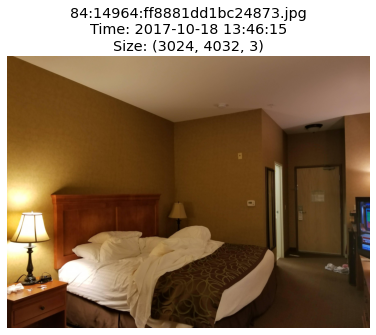

In [42]:
sample_df = select_data(train_df, None, 14964, None)
show_images(sample_df)

### Hotel 55404 - 2 images

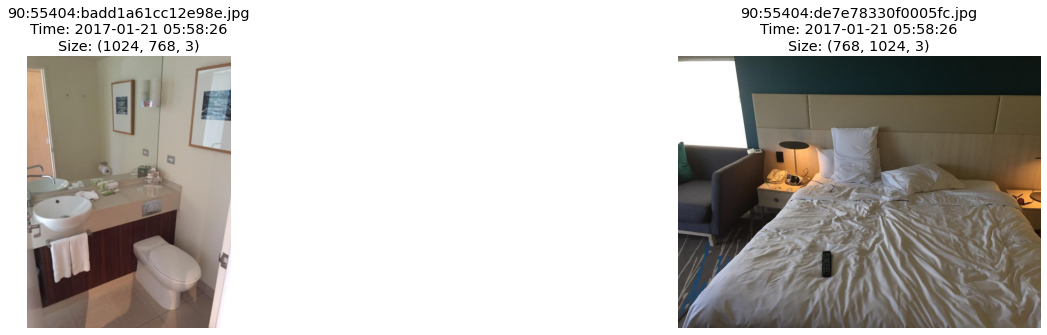

In [43]:
sample_df = select_data(train_df, None, 55404, None)
show_images(sample_df)

## Test images

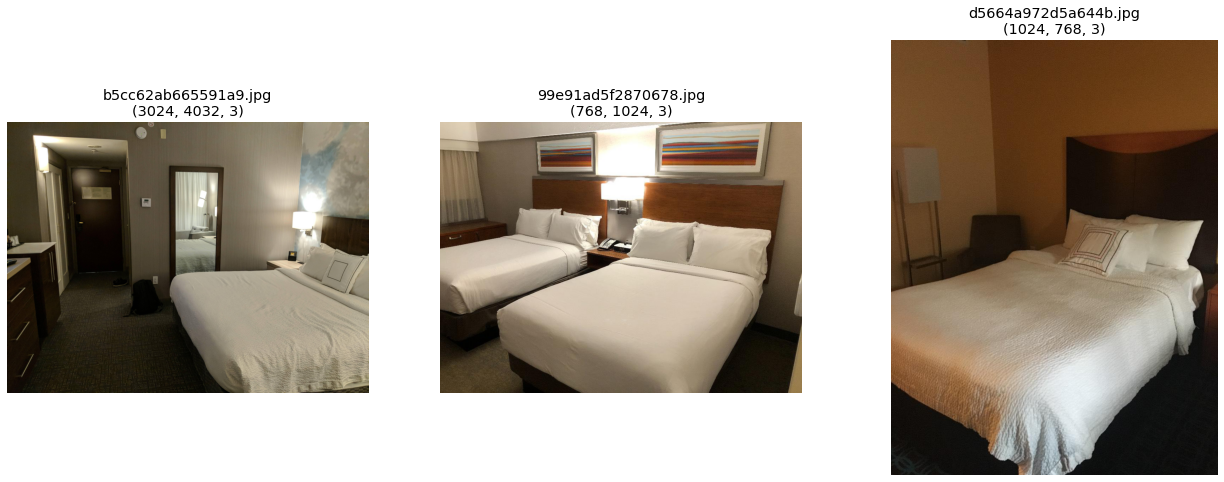

In [44]:
test_images = os.listdir(data_folder + "test_images/")

fig, axs= plt.subplots(1,3, figsize=(22,8))

for i in range(0, len(test_images)):
    image = Image.open(data_folder + "test_images/" + test_images[i])
    axs[i].imshow(image)
    axs[i].set_title(f"{test_images[i]}\n{np.shape(image)}")
    axs[i].axis("off")       